## Import Library

Pada bagian ini, kita mengimpor berbagai library yang diperlukan untuk analisis dan pemrosesan data. Berikut adalah deskripsi singkat dari masing-masing library yang digunakan:

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

In [2]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('paypal_reviews.csv')

## Tahap Preprocessing

Pada tahap preprocessing, kita melakukan beberapa langkah untuk membersihkan dan mempersiapkan data sebelum digunakan dalam model machine learning. Berikut adalah penjelasan dari setiap langkah yang dilakukan:

1. **Pembersihan Teks**:
    - Mengubah teks menjadi huruf kecil.
    - Menghapus URL dan karakter non-alfabet.
    - Menghapus spasi berlebih dan karakter yang tidak diperlukan.

2. **Tokenisasi dan Stemming**:
    - Melakukan tokenisasi pada teks untuk memisahkan kata-kata.
    - Menghapus stopwords dalam bahasa Inggris dan Indonesia.
    - Melakukan stemming pada kata-kata dalam teks untuk mengurangi kata ke bentuk dasarnya.

3. **Encoding Label**:
    - Mengubah label kategori menjadi angka menggunakan `LabelEncoder`.

Tahap preprocessing ini sangat penting untuk memastikan data yang digunakan dalam model machine learning bersih dan relevan, sehingga dapat meningkatkan akurasi dan performa model.


In [4]:
stemmer = PorterStemmer()
stop_words_en = set(stopwords.words('english'))
stop_words_id = set(stopwords.words('indonesian'))
stop_words = stop_words_en.union(stop_words_id)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

df['content'] = df['content'].astype(str).apply(clean_text)

In [5]:
print(f'Sisa data setelah penghapusan: {len(df)} baris')

Sisa data setelah penghapusan: 20000 baris


In [6]:
# Encoding label
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [7]:
X = df['content'].values.reshape(-1, 1)
y = df['sentiment']

In [8]:
label_counts = df['sentiment'].value_counts()
print(label_counts)

sentiment
2    13003
1     3566
0     3431
Name: count, dtype: int64


In [9]:
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
for i in range(3):
    print(f'Label {i} is mapped to category: {label_mapping[i]}')

Label 0 is mapped to category: negative
Label 1 is mapped to category: neutral
Label 2 is mapped to category: positive


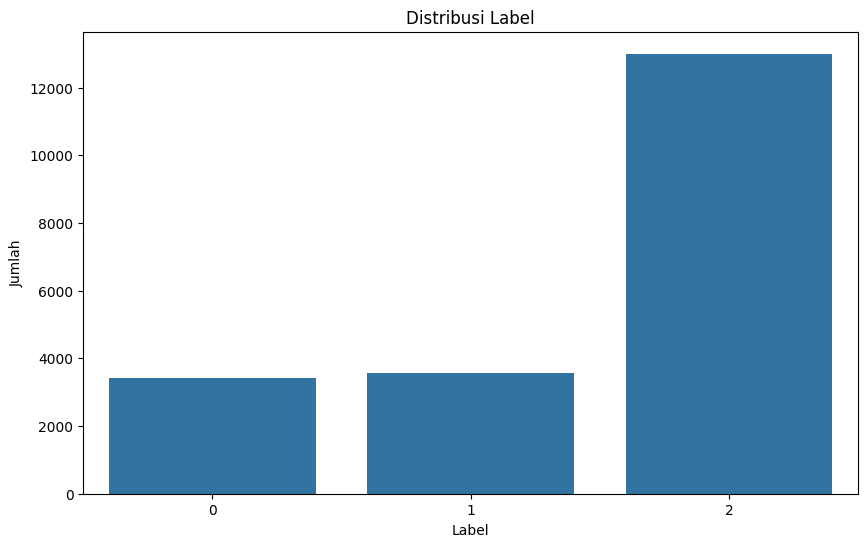

In [10]:
# Plot distribusi label
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

## Eksperimen 1: LSTM + Tokenizer + Pembagian Data 80/20

Pada eksperimen pertama ini, kita menggunakan model LSTM (Long Short-Term Memory) dengan tokenizer untuk memproses data teks. Berikut adalah langkah-langkah yang dilakukan:

1. **Pembagian Data**:
    - Data dibagi menjadi dua bagian: 80% untuk data latih dan 20% untuk data uji.
    - Pembagian ini dilakukan secara stratified untuk memastikan distribusi label yang sama di kedua set data.

2. **Tokenisasi**:
    - Menggunakan tokenizer dengan jumlah kata maksimal 10.000 dan token khusus untuk kata yang tidak dikenal (`<OOV>`).
    - Tokenizer ini dilatih pada data latih untuk membuat indeks kata.

3. **Pembuatan Sequence dan Padding**:
    - Data teks diubah menjadi sequence angka berdasarkan indeks kata yang dihasilkan oleh tokenizer.
    - Sequence ini kemudian dipadatkan (padding) hingga panjang maksimal 150 kata.

4. **Arsitektur Model**:
    - Model menggunakan embedding layer dengan dimensi 256.
    - Spatial dropout diterapkan pada embedding layer untuk regularisasi.
    - Dua layer BiLSTM (Bidirectional LSTM) digunakan, masing-masing dengan 128 dan 64 unit.
    - Batch normalization diterapkan setelah layer BiLSTM pertama.
    - Dua dense layer dengan 128 dan 64 unit.
    - Output layer menggunakan softmax activation untuk klasifikasi multi-kelas.

5. **Optimisasi dan Pelatihan**:
    - Optimizer AdamW dengan learning rate 0.0003 digunakan.
    - Callbacks seperti ReduceLROnPlateau dan EarlyStopping digunakan untuk meningkatkan pelatihan.
    - Class weights dihitung untuk menangani ketidakseimbangan kelas.
    - Model dilatih selama 15 epoch dengan batch size 16.

6. **Evaluasi**:
    - Model dievaluasi pada data latih dan data uji untuk menghitung akurasi.
    - Hasil akurasi dilaporkan untuk kedua set data.

Eksperimen ini bertujuan untuk mengevaluasi performa model LSTM dengan tokenizer dan pembagian data 80/20.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

In [12]:
# Konversi ke list string jika perlu
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

In [13]:
#Meningkatkan tokenizer dengan lebih banyak kata
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [14]:
# Meningkatkan panjang maksimal sequence
max_length = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = AdamW(learning_rate=0.0003, weight_decay=1e-5)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

def scheduler(epoch, lr):
    return lr * 0.95 if epoch > 1 else lr

lr_callback = LearningRateScheduler(scheduler)

In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [17]:
# Training
history = model1.fit(
    X_train_padded, y_train,
    epochs=15,
    validation_data=(X_test_padded, y_test),
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop, lr_callback],
    verbose=1
)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.6051 - loss: 1.0412 - val_accuracy: 0.8292 - val_loss: 0.6251 - learning_rate: 3.0000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8522 - loss: 0.5574 - val_accuracy: 0.8615 - val_loss: 0.5314 - learning_rate: 3.0000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.9145 - loss: 0.3723 - val_accuracy: 0.8903 - val_loss: 0.4484 - learning_rate: 2.8500e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.9366 - loss: 0.2910 - val_accuracy: 0.9020 - val_loss: 0.4406 - learning_rate: 2.7075e-04
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9494 - loss: 0.2459 - val_accuracy: 0.9135 - val_loss: 0.3821 - learning_rate: 2.5721e-04
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9586 - loss: 0.2045 - val_accuracy: 0.9053 - val_loss: 0.5070 - learning_rate: 2.4435e-04
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [18]:
model1.save('LSTM+Tokenizer.h5')

train_loss, train_accuracy = model1.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model1.evaluate(X_test_padded, y_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9760 - loss: 0.1644
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9212 - loss: 0.3686


In [19]:
print(f'Experiment 1 Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Experiment 1 Testing Accuracy: {test_accuracy * 100:.2f}%')

Experiment 1 Training Accuracy: 97.53%
Experiment 1 Testing Accuracy: 91.35%


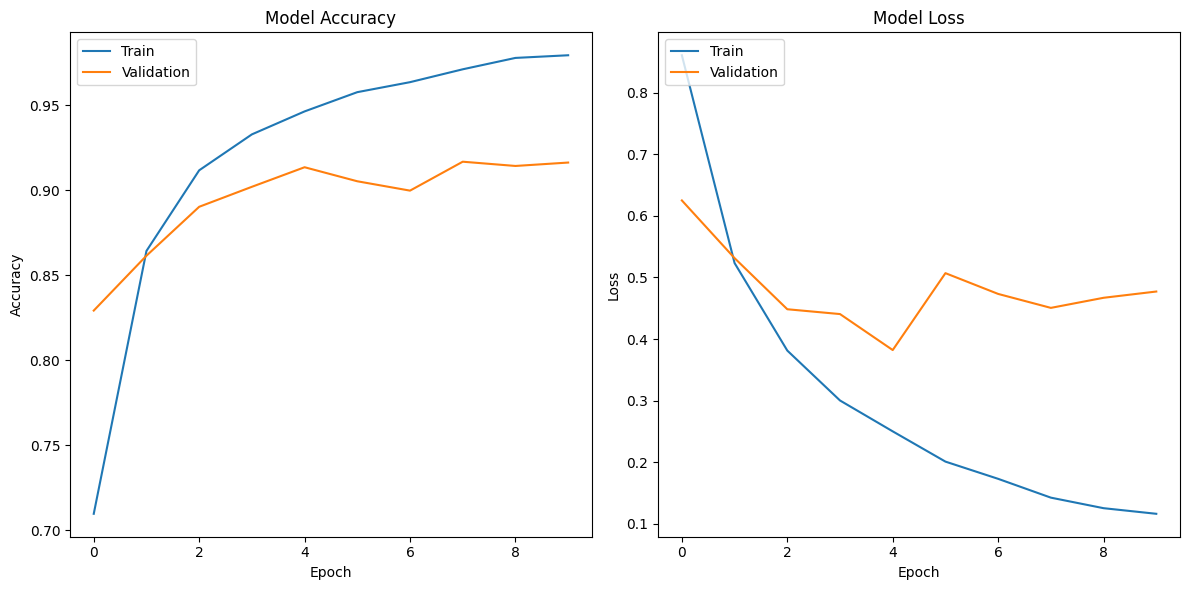

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Eksperimen 2: LSTM + TF-IDF + Pembagian Data 70/30

Pada eksperimen kedua ini, kita menggunakan model LSTM (Long Short-Term Memory) dengan TF-IDF (Term Frequency-Inverse Document Frequency) untuk memproses data teks. Berikut adalah langkah-langkah yang dilakukan:

1. **Pembagian Data**:
    - Data dibagi menjadi dua bagian: 70% untuk data latih dan 30% untuk data uji.
    - Pembagian ini dilakukan secara stratified untuk memastikan distribusi label yang sama di kedua set data.

2. **TF-IDF**:
    - Menggunakan TF-IDF vectorizer untuk mengubah teks menjadi vektor numerik.
    - Vectorizer ini dilatih pada data latih untuk membuat representasi vektor dari teks.

3. **Arsitektur Model**:
    - Model menggunakan beberapa dense layer dengan unit yang berbeda.
    - Batch normalization diterapkan setelah beberapa layer dense.
    - Dropout diterapkan untuk regularisasi.
    - Output layer menggunakan softmax activation untuk klasifikasi multi-kelas.

4. **Optimisasi dan Pelatihan**:
    - Optimizer AdamW dengan learning rate 0.0003 digunakan.
    - Callbacks seperti ReduceLROnPlateau dan EarlyStopping digunakan untuk meningkatkan pelatihan.
    - Class weights dihitung untuk menangani ketidakseimbangan kelas.
    - Model dilatih selama 15 epoch dengan batch size 32.

5. **Evaluasi**:
    - Model dievaluasi pada data latih dan data uji untuk menghitung akurasi.
    - Hasil akurasi dilaporkan untuk kedua set data.

Eksperimen ini bertujuan untuk mengevaluasi performa model LSTM dengan TF-IDF dan pembagian data 70/30.


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment']
)

In [22]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [23]:
# Model
model2 = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Optimizer
optimizer = AdamW(learning_rate=0.0003, weight_decay=1e-6)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True, verbose=1)

def scheduler(epoch, lr):
    return lr * 0.95 if epoch > 1 else lr

lr_callback = LearningRateScheduler(scheduler)

In [26]:
# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [27]:
# Training
history = model2.fit(
    X_train_tfidf, y_train,
    epochs=15,
    validation_data=(X_test_tfidf, y_test),
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop, lr_callback],
    verbose=1
)

Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4727 - loss: 1.2094 - val_accuracy: 0.8337 - val_loss: 0.6259 - learning_rate: 3.0000e-04
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7788 - loss: 0.5463 - val_accuracy: 0.8615 - val_loss: 0.3591 - learning_rate: 3.0000e-04
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8813 - loss: 0.3023 - val_accuracy: 0.8670 - val_loss: 0.3726 - learning_rate: 2.8500e-04
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9172 - loss: 0.2065 - val_accuracy: 0.8823 - val_loss: 0.3558 - learning_rate: 2.7075e-04
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9433 - loss: 0.1433 - val_accuracy: 0.8778 - val_loss: 0.3862 - learning_rate: 2.5721e-04
Epoch 6/15
431/438 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9570 - loss: 0.1157
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.887037794105709e-05.
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9

In [28]:
model2.save('LSTM+Word2Vec.h5')

train_loss, train_accuracy = model2.evaluate(X_train_tfidf, y_train)
test_loss, test_accuracy = model2.evaluate(X_test_tfidf, y_test)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9911 - loss: 0.0285
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8889 - loss: 0.4406


In [29]:
print(f'Experiment 2 Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Experiment 2 Testing Accuracy: {test_accuracy * 100:.2f}%')

Experiment 2 Training Accuracy: 99.13%
Experiment 2 Testing Accuracy: 89.18%


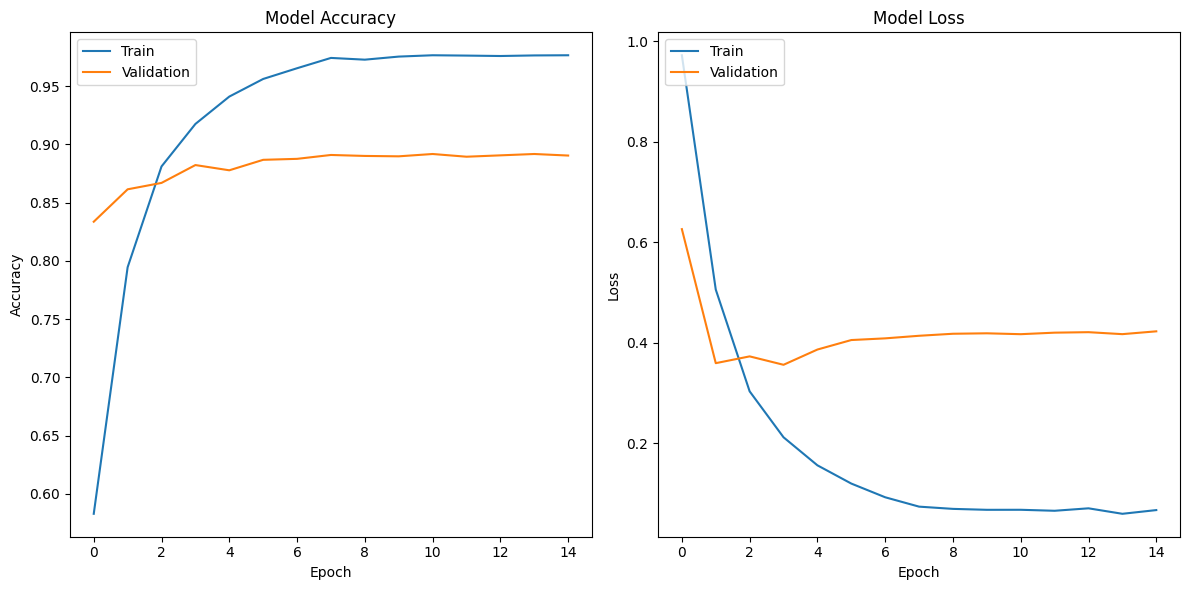

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Eksperimen 3: BiLSTM + Tokenizer + Pembagian Data 75/25

Pada eksperimen ketiga ini, kita menggunakan model BiLSTM (Bidirectional Long Short-Term Memory) dengan Tokenizer dan pembagian data 75/25. Berikut adalah langkah-langkah yang dilakukan:

1. **Pembagian Data**:
	- Data dibagi menjadi dua bagian: 75% untuk data latih dan 25% untuk data uji.
	- Pembagian ini dilakukan secara stratified untuk memastikan distribusi label yang sama di kedua set data.

2. **Tokenisasi**:
	- Menggunakan tokenizer dengan jumlah kata maksimal 10.000 dan token khusus untuk kata yang tidak dikenal (`<OOV>`).
	- Tokenizer ini dilatih pada data latih untuk membuat indeks kata.

3. **Pembuatan Sequence dan Padding**:
	- Data teks diubah menjadi sequence angka berdasarkan indeks kata yang dihasilkan oleh tokenizer.
	- Sequence ini kemudian dipadatkan (padding) hingga panjang maksimal 150 kata.

4. **Arsitektur Model**:
	- Model menggunakan embedding layer dengan dimensi 256.
	- Spatial dropout diterapkan pada embedding layer untuk regularisasi.
	- Tiga layer BiLSTM digunakan, masing-masing dengan 128, 64, dan 32 unit.
	- Batch normalization diterapkan setelah layer BiLSTM pertama dan ketiga.
	- Dua dense layer dengan 128 dan 64 unit digunakan sebelum output layer.
	- Output layer menggunakan softmax activation untuk klasifikasi multi-kelas.

5. **Optimisasi dan Pelatihan**:
	- Optimizer Adam dengan learning rate 0.0005 digunakan.
	- Callbacks seperti ReduceLROnPlateau dan EarlyStopping digunakan untuk meningkatkan pelatihan.
	- Model dilatih selama 10 epoch dengan batch size 16.

6. **Evaluasi**:
	- Model dievaluasi pada data latih dan data uji untuk menghitung akurasi.
	- Hasil akurasi dilaporkan untuk kedua set data.

Eksperimen ini bertujuan untuk mengevaluasi performa model BiLSTM dengan Tokenizer dan pembagian data 75/25.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['sentiment'],
    test_size=0.25,
    random_state=42,
    stratify=df['sentiment']
)

In [32]:
# Memperbesar vocabulary dan menggunakan out-of-vocabulary token
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Menggunakan max_length yang lebih panjang
max_length = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [33]:
# Model yang dioptimasi
model_optimized = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=False)),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
# Optimizer dengan learning rate yang lebih rendah
optimizer = Adam(learning_rate=0.0005)

model_optimized.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks untuk meningkatkan training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [35]:
# Training dengan lebih banyak epochs
history = model_optimized.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_test_padded, y_test),
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.6675 - loss: 0.7550 - val_accuracy: 0.8726 - val_loss: 0.3346 - learning_rate: 5.0000e-04
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8969 - loss: 0.2960 - val_accuracy: 0.8944 - val_loss: 0.2819 - learning_rate: 5.0000e-04
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9413 - loss: 0.1839 - val_accuracy: 0.8896 - val_loss: 0.2842 - learning_rate: 5.0000e-04
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.9592 - loss: 0.1294 - val_accuracy: 0.9210 - val_loss: 0.3060 - learning_rate: 5.0000e-04
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9679 - loss: 0.1116
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.9679 - loss: 0.1116 - val_accuracy: 0.9264 - val_loss: 0.2826 - learning_rate: 5.0000e-04
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - ac

In [36]:
model_optimized.save('BiLSTM+GloVe.h5')

train_loss, train_accuracy = model_optimized.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model_optimized.evaluate(X_test_padded, y_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9894 - loss: 0.0387
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9296 - loss: 0.3342


In [37]:
print(f'Optimized Model Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Optimized Model Testing Accuracy: {test_accuracy * 100:.2f}%')

Optimized Model Training Accuracy: 99.03%
Optimized Model Testing Accuracy: 93.02%


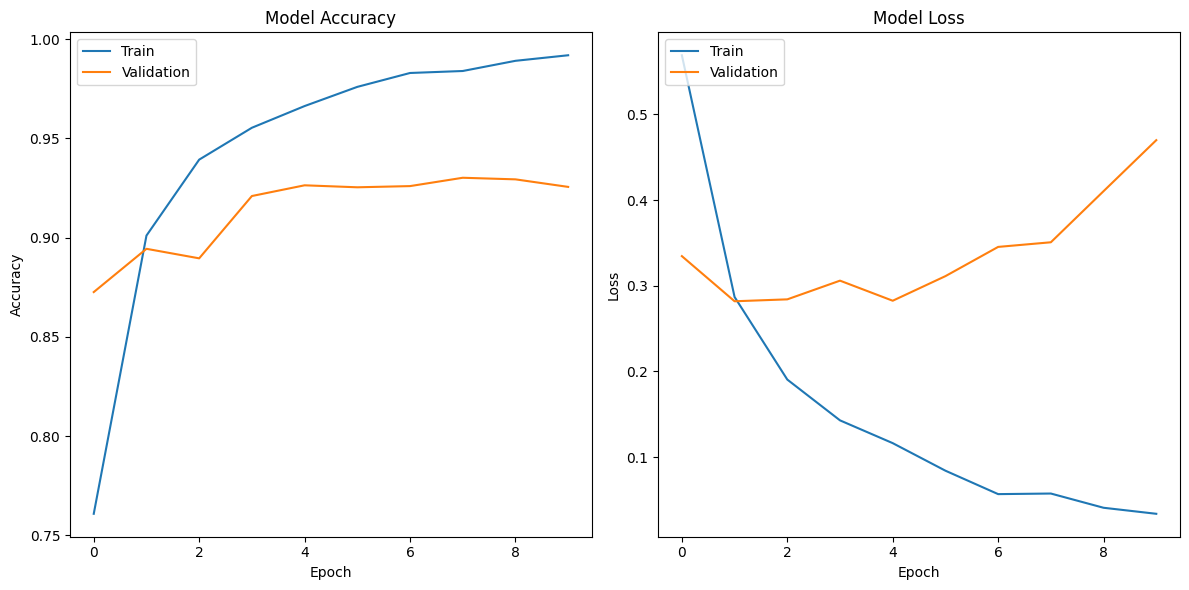

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()